# 텍스트 키워드 분석

In [1]:
import matplotlib
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=fontpath, size=8) 

In [2]:
#폰트종류설정
plt.rcParams["font.family"] = 'NanumGothic'

#폰트크기설정
#plt.rcParams["font.size"] = 20

## 데이터 전처리

In [3]:
import konlpy
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/tmp/ipykernel_2426/691330863.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
2023-03-24 13:53:02.120253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 13:53:02.272617: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

In [4]:
file = open('../data/stop_word.txt', 'r')

stopWord = []
l = ''
while True:
    l = file.readline()
    stopWord.append(l[:-1])
    if l == '':
        break

In [5]:
len(stopWord)

676

In [6]:
import pandas as pd
import numpy as np
data_df = pd.read_csv('../data/ulsan_rest_review_ver3.csv')
data_df.head()

,p_id,place_id,user_id,score,comment
0,0,225토마토스트릿,cu,5,분위기가 진짜 미쳤습니다. 외부와 단절된 느낌으로다가 아늑하고 좋아요.
1,0,225토마토스트릿,냠념뇸,4,코스로 먹었습니다. 초반 에피타이져는 굉장히 맛있었는데 파스타가 너무 짜서 뒤에 스...
2,0,225토마토스트릿,김영,2,너무 어둡고 밀폐된 공간에 벨을 누르고 문 열어주면 입장에 허걱.카프레제 샐러드는 ...
3,0,225토마토스트릿,애니비아,2,일단 특이하게 벨 누르는? 인테리어도 특이하고 이런 식당이 많이 없으니까 신기하긴 ...
4,0,225토마토스트릿,라떼처돌이,5,다 맛있음! 뭘 시켜도 맛있을 것같음.양이 보기보다 많아 배에 차곡차곡 쌓이는 느낌.


In [7]:
print(data_df['comment'].nunique())
print(data_df['score'].nunique())

data_df.drop_duplicates(subset=['comment'], inplace=True)

35637
5


In [8]:
print(data_df.isnull().sum())

data_df = data_df.dropna(how='any')

p_id         0
place_id     0
user_id     18
score        0
comment      1
dtype: int64


In [9]:
data_df['comment'] = data_df['comment'].str.replace("[^ㄱ-하-ㅣ가-힣 ]", "")

/tmp/ipykernel_2426/2728893579.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['comment'] = data_df['comment'].str.replace("[^ㄱ-하-ㅣ가-힣 ]", "")


In [10]:
data_df['comment'].replace('', np.nan, inplace=True)
print(len(data_df))
print(data_df.isnull().sum())

35619
p_id         0
place_id     0
user_id      0
score        0
comment     51
dtype: int64


In [11]:
data_df.head()

,p_id,place_id,user_id,score,comment
0,0,225토마토스트릿,cu,5,분위기가 진짜 미쳤습니다 외부와 단절된 느낌으로다가 아늑하고 좋아요
1,0,225토마토스트릿,냠념뇸,4,코스로 먹었습니다 초반 에피타이져는 굉장히 맛있었는데 파스타가 너무 짜서 뒤에 스테...
2,0,225토마토스트릿,김영,2,너무 어둡고 밀폐된 공간에 벨을 누르고 문 열어주면 입장에 허걱카프레제 샐러드는 너...
3,0,225토마토스트릿,애니비아,2,일단 특이하게 벨 누르는 인테리어도 특이하고 이런 식당이 많이 없으니까 신기하긴 함...
4,0,225토마토스트릿,라떼처돌이,5,다 맛있음 뭘 시켜도 맛있을 것같음양이 보기보다 많아 배에 차곡차곡 쌓이는 느낌


In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35619 entries, 0 to 54520
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   p_id      35619 non-null  int64 
 1   place_id  35619 non-null  object
 2   user_id   35619 non-null  object
 3   score     35619 non-null  int64 
 4   comment   35568 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


## 토큰화 및 불용어 제거

In [13]:
from konlpy.tag import Mecab

mecab =Mecab()

reviews = []
for sentence in data_df['comment']:
    reviews.append([word for word in mecab.morphs(str(sentence)) if not word in stopWord])

reviews[:3]

[['분위기', '진짜', '미쳤', '외부', '단절', '된', '느낌', '다가', '아늑', '고', '좋', '아요'],
 ['코스',
  '먹',
  '었',
  '초반',
  '피타',
  '져',
  '는',
  '굉장히',
  '맛있',
  '었',
  '는데',
  '파스타',
  '너무',
  '짜',
  '서',
  '뒤',
  '스테이크',
  '맛',
  '안',
  '느껴져서',
  '아쉽',
  '브루',
  '쉐타',
  '스프',
  '는',
  'ㄹ',
  'ㅇ',
  '존',
  '맛'],
 ['너무',
  '어둡',
  '고',
  '밀폐',
  '된',
  '공간',
  '벨',
  '누르',
  '고',
  '문',
  '열',
  '주',
  '면',
  '입장',
  '카프레',
  '샐러드',
  '는',
  '너무',
  '짜',
  '서',
  '남김',
  '그나마',
  '스테이크',
  '는',
  '먹',
  '만',
  '함']]

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
print(tokenizer.word_index)

{'고': 1, '는': 2, '도': 3, '은': 4, '좋': 5, '맛있': 6, '맛': 7, '먹': 8, '있': 9, '어요': 10, '한': 11, '게': 12, '음': 13, '다': 14, '었': 15, '네요': 16, '는데': 17, '아요': 18, '지': 19, '너무': 20, '곳': 21, '없': 22, '친절': 23, '많': 24, '았': 25, '기': 26, '음식': 27, '가격': 28, '시': 29, '입니다': 30, '면': 31, '고기': 32, '만': 33, '안': 34, '않': 35, '집': 36, '수': 37, '합니다': 38, '같': 39, '분': 40, '했': 41, '잘': 42, 'ㅎ': 43, '적': 44, '님': 45, '함': 46, '어서': 47, '커피': 48, '주': 49, '맛집': 50, '깔끔': 51, '분위기': 52, '양': 53, '괜찮': 54, '되': 55, '인': 56, '서': 57, '보': 58, '직원': 59, '요': 60, '울산': 61, '해서': 62, '사람': 63, '듯': 64, '라': 65, '거': 66, '최고': 67, '정말': 68, '주차': 69, '니': 70, '해': 71, '뷰': 72, '많이': 73, '더': 74, '보다': 75, '할': 76, '아서': 77, '추천': 78, '밥': 79, '넓': 80, '원': 81, '싶': 82, '주차장': 83, '방문': 84, '서비스': 85, '맛나': 86, '나오': 87, '반찬': 88, '번': 89, '생각': 90, '진짜': 91, '겠': 92, '식사': 93, '갔': 94, '메뉴': 95, '그냥': 96, '손': 97, '느낌': 98, '카페': 99, '주문': 100, '사장': 101, '비': 102, '아주': 103, '정도': 104, '돈': 105, '불고기':

## 빈도수 확인

In [15]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value

    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value

print("전체 단어 수 :", words_cnt)
print("빈도가 {}이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율: {}.".format((rare_cnt / words_cnt)*100))
print("희귀 단어 등장 빈도 비율: {}".format((rare_freq / words_freq)*100))

전체 단어 수 : 18321
빈도가 2이하인 희귀 단어 수 : 10849
희귀 단어 비율: 59.21619998908356.
희귀 단어 등장 빈도 비율: 2.269449378935991


In [16]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

7474


In [17]:
print('리뷰 최대 길이:', max(len(l) for l in reviews))
print('리뷰 평균 길이:', sum(map(len, reviews))/len(reviews))

리뷰 최대 길이: 514
리뷰 평균 길이: 16.468008647070384


Text(0, 0.5, 'number of samples')

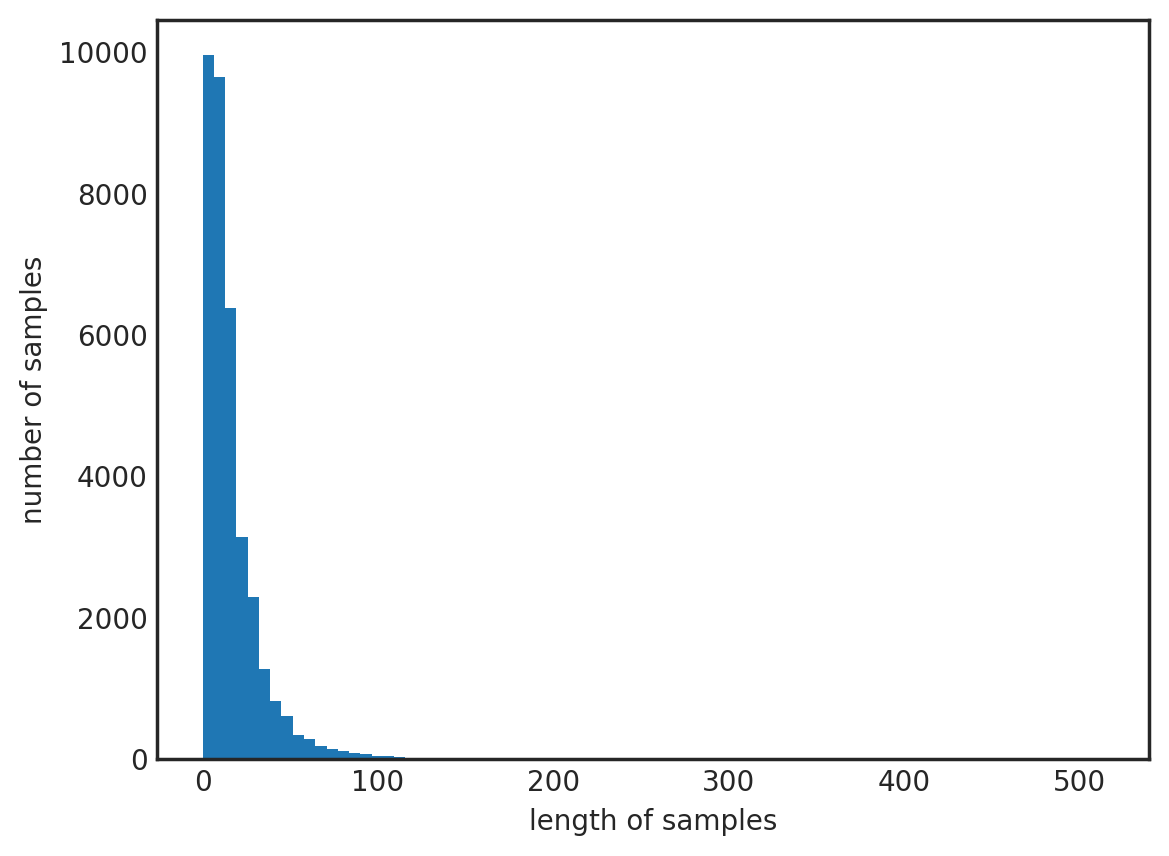

In [18]:
plt.hist([len(s) for s in reviews], bins= 80)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

In [19]:
tagger = Mecab()

nouns = []
for idx in data_df.index:
    review = data_df.loc[idx, 'comment']
    for noun in tagger.nouns(str(review)):
        nouns.append(noun)
        
nouns[:10]  

['분위기', '외부', '단절', '느낌', '코스', '초반', '피타', '파스타', '뒤', '스테이크']

## 형태소 분석을 이용한 명사 추출

In [20]:
nouns = []
for idx in data_df.index:
    review = data_df.loc[idx, 'comment']
    for noun in tagger.nouns(str(review)):
        if noun not in stopWord:
            nouns.append(noun)

nouns[:10]

['분위기', '외부', '단절', '느낌', '코스', '초반', '피타', '파스타', '뒤', '스테이크']

## 단어 빈도수 측정

In [21]:
from collections import Counter

nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(50))
top_nouns

{'맛': 8934,
 '곳': 3111,
 '친절': 3055,
 '음식': 2961,
 '가격': 2960,
 '고기': 2790,
 '집': 2550,
 '수': 2296,
 '커피': 1897,
 '맛집': 1860,
 '분위기': 1778,
 '직원': 1635,
 '울산': 1584,
 '사람': 1569,
 '듯': 1512,
 '거': 1500,
 '최고': 1484,
 '양': 1428,
 '주차': 1365,
 '뷰': 1280,
 '추천': 1224,
 '밥': 1215,
 '원': 1158,
 '주차장': 1141,
 '분': 1138,
 '방문': 1119,
 '서비스': 1106,
 '게': 1067,
 '반찬': 1063,
 '만': 1041,
 '생각': 1037,
 '번': 1027,
 '식사': 988,
 '메뉴': 974,
 '손': 948,
 '카페': 938,
 '느낌': 931,
 '주문': 917,
 '사장': 908,
 '정도': 890,
 '돈': 885,
 '불고기': 856,
 '바다': 855,
 '식당': 853,
 '빵': 830,
 '편': 824,
 '굿': 782,
 '국물': 758,
 '자리': 746,
 '점심': 737}

## 단어 빈도 시각화

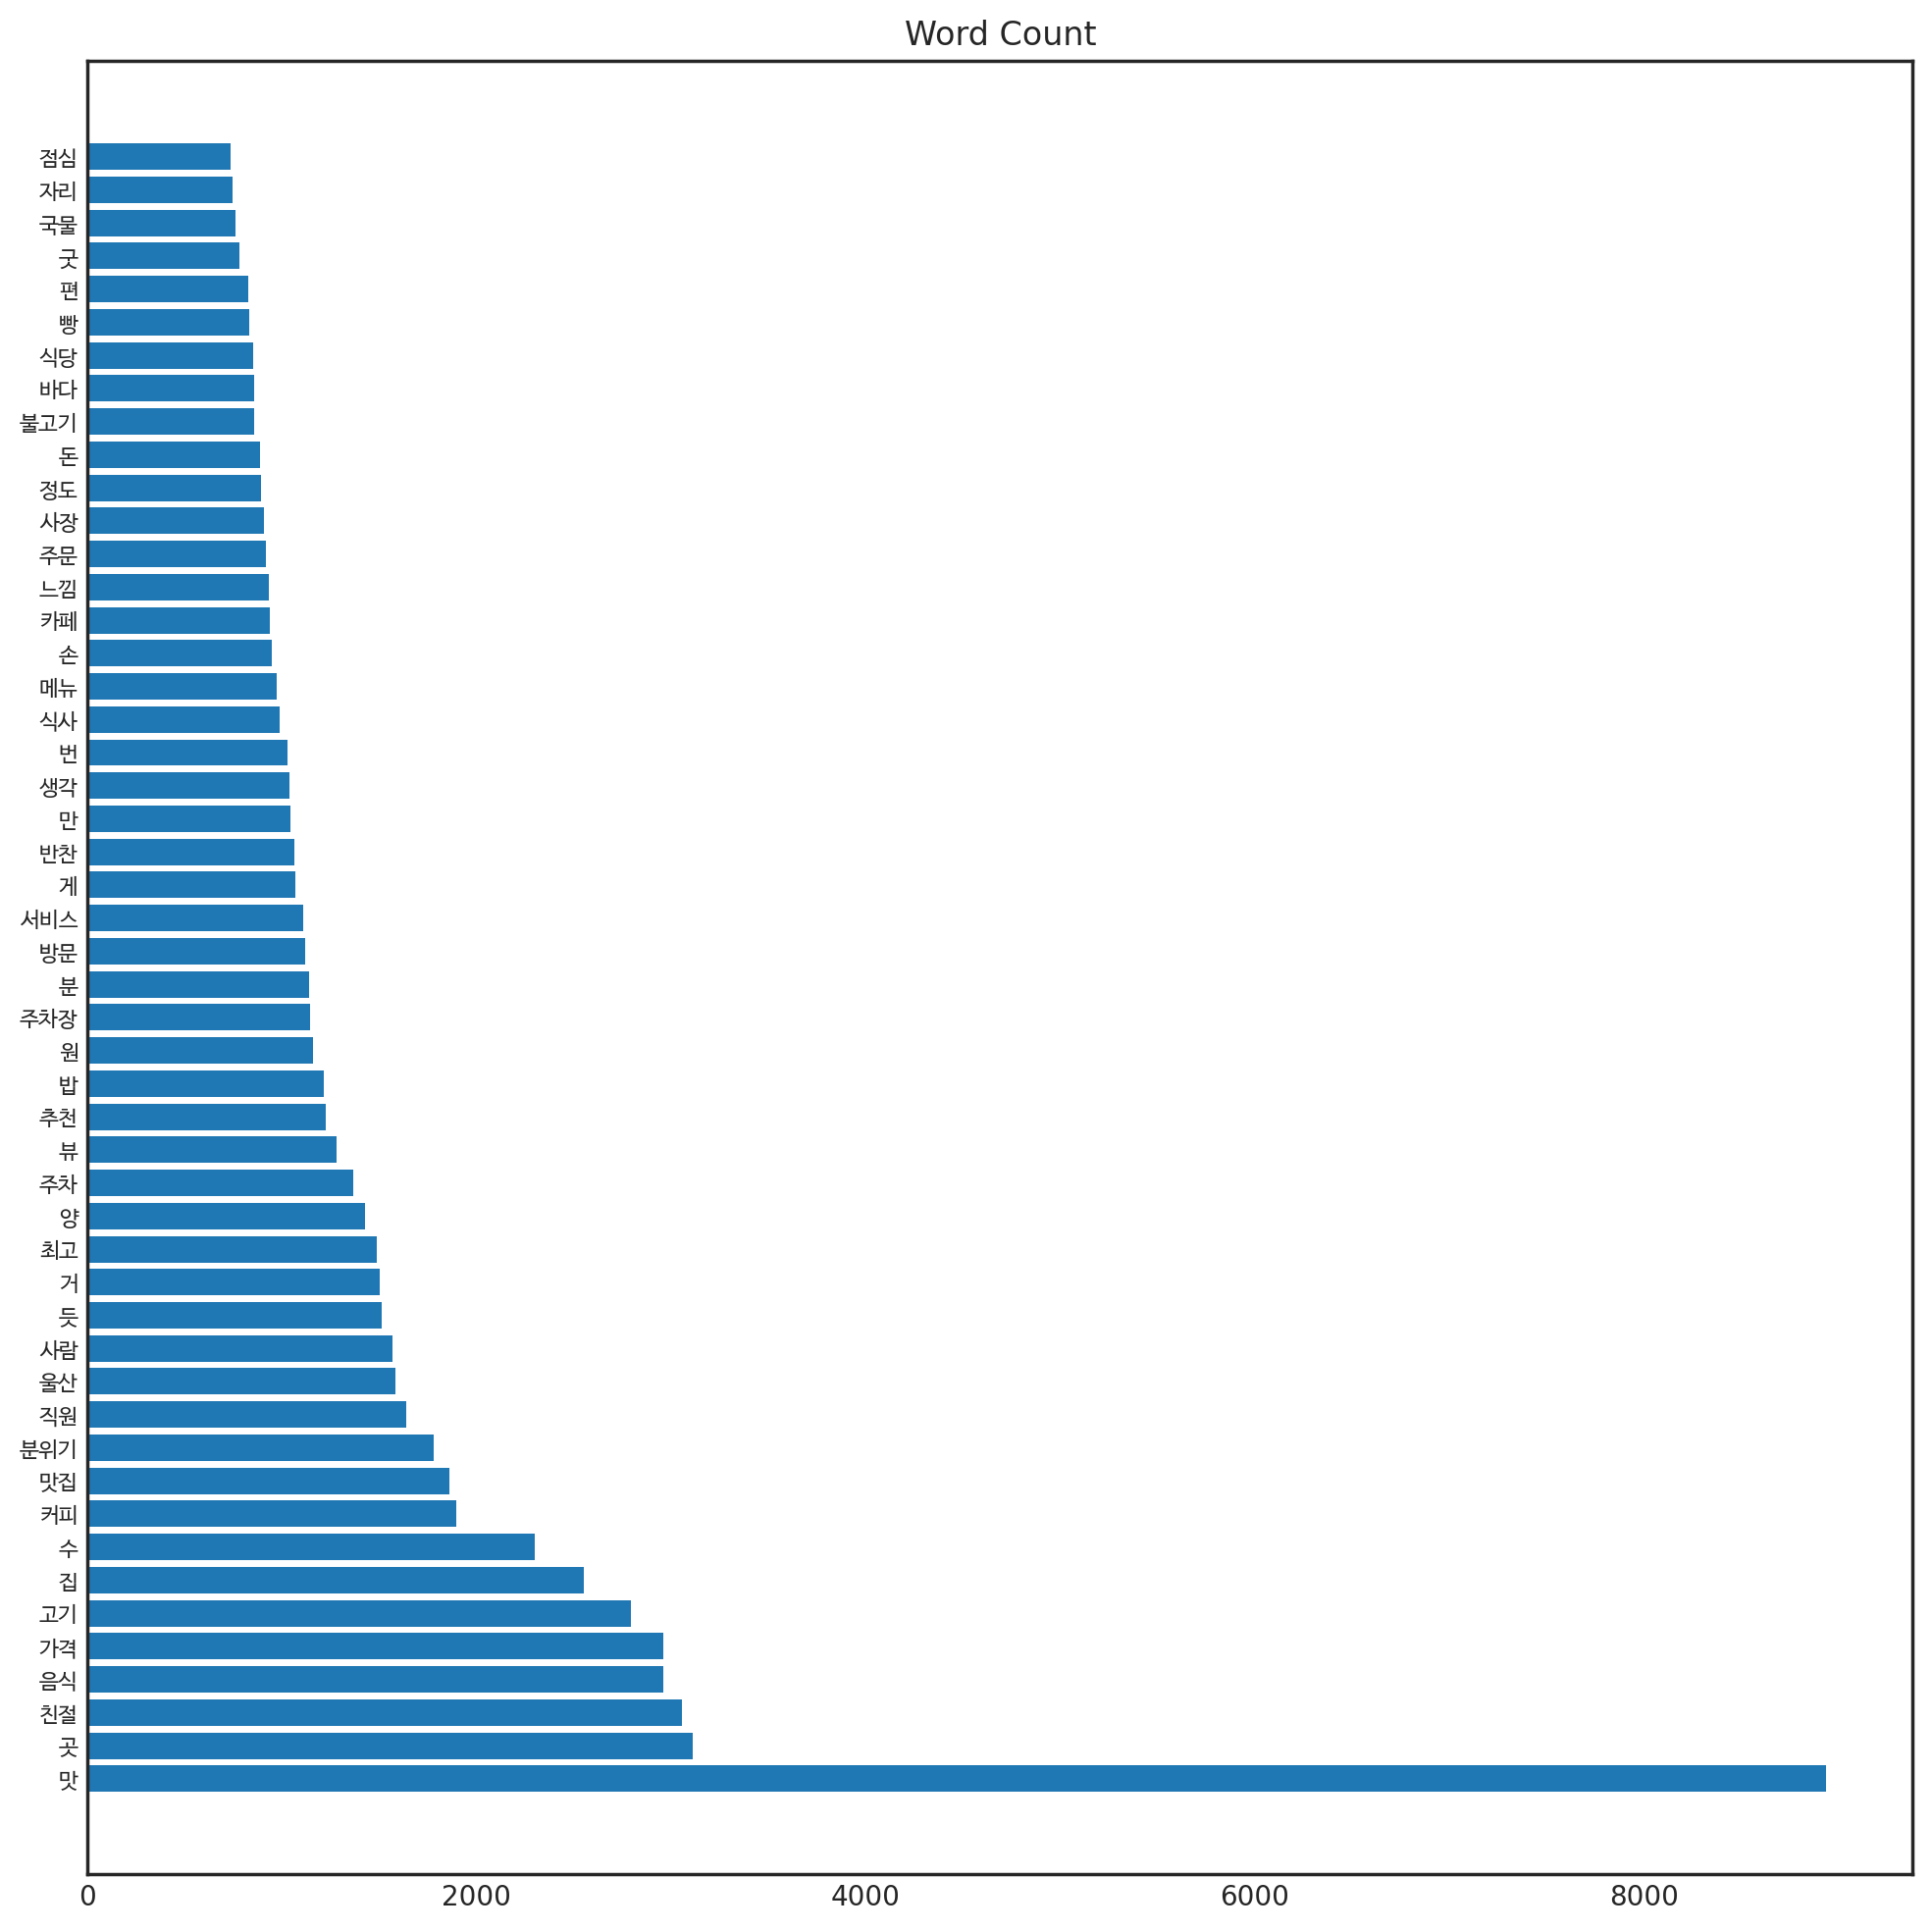

In [22]:
import numpy as np
y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(12,12))
plt.barh(y_pos, top_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_nouns.keys(), fontproperties = fontprop)
plt.show();

## WordCloud

In [23]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', font_path=fontpath)
wc.generate_from_frequencies(top_nouns)

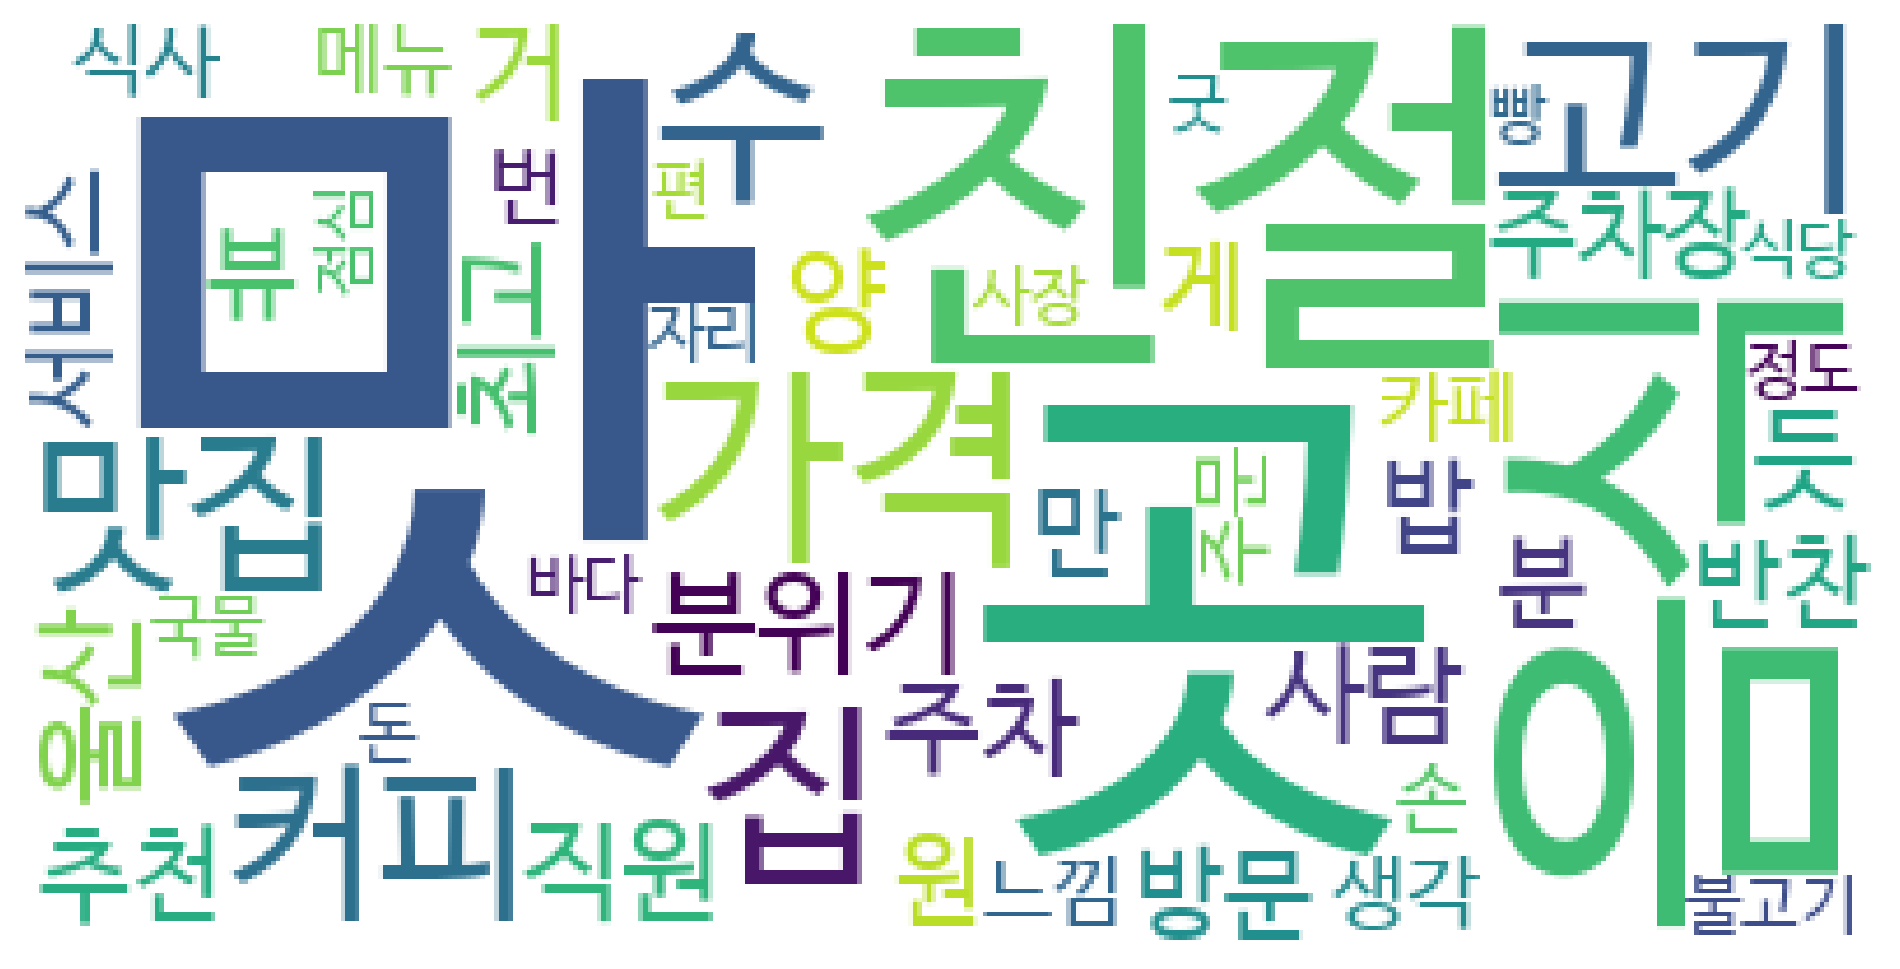

In [24]:
figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()